Invalid dates in train: 
Empty DataFrame
Columns: [date, store, item, sales]
Index: []
Invalid dates in test: 
Empty DataFrame
Columns: [id, date, store, item]
Index: []
Before dropping NaN values: 913000 rows
date             0
store            0
item             0
sales            0
year             0
month            0
day              0
dayofweek        0
lag1           500
lag7          3500
lag30        15000
dtype: int64
After dropping NaN values: 898000 rows
Training time: 55.529773473739624 seconds
Mean Absolute Error: 6.209440478841871
Mean Squared Error: 64.81879166982183


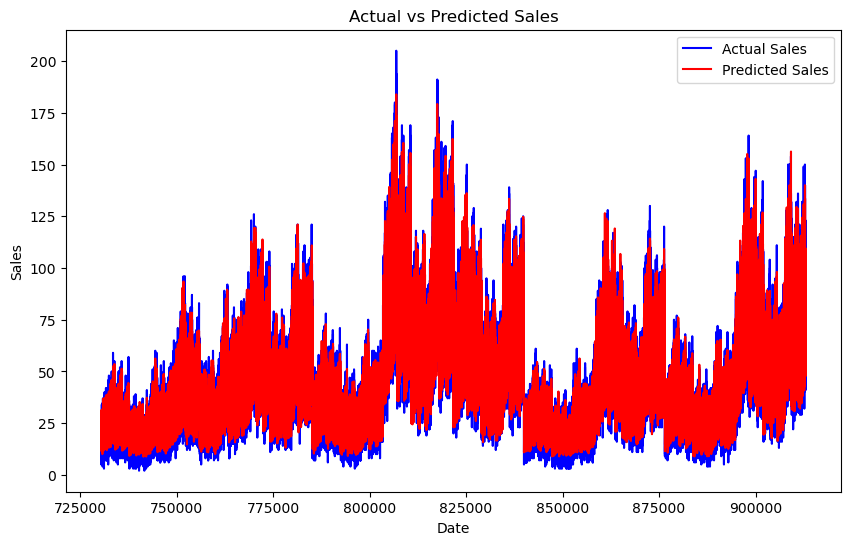

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import time

# Load the datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

# Clean and convert 'date' to datetime
train['date'] = pd.to_datetime(train['date'], format='%Y-%m-%d', errors='coerce')
test['date'] = pd.to_datetime(test['date'], format='%Y-%m-%d', errors='coerce')

# Check if any rows have invalid dates and print them out for debugging
invalid_train_dates = train[train['date'].isna()]
invalid_test_dates = test[test['date'].isna()]

print(f"Invalid dates in train: \n{invalid_train_dates}")
print(f"Invalid dates in test: \n{invalid_test_dates}")

# Feature engineering for the train and test sets
train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train['day'] = train['date'].dt.day
train['dayofweek'] = train['date'].dt.dayofweek

test['year'] = test['date'].dt.year
test['month'] = test['date'].dt.month
test['day'] = test['date'].dt.day
test['dayofweek'] = test['date'].dt.dayofweek

# Create lag features for the training data
train['lag1'] = train.groupby(['store', 'item'])['sales'].shift(1)
train['lag7'] = train.groupby(['store', 'item'])['sales'].shift(7)
train['lag30'] = train.groupby(['store', 'item'])['sales'].shift(30)

# Before dropping rows with NaN, check how many rows have missing values
print(f"Before dropping NaN values: {train.shape[0]} rows")

# Checking NaN values after creating lag features
print(train.isna().sum())  # Check how many NaNs are in each column

# Drop rows with NaN values in 'lag1', 'lag7', or 'lag30' columns (lag features)
train = train.dropna(subset=['lag1', 'lag7', 'lag30'])

# After dropping NaN values, check the dataset size
print(f"After dropping NaN values: {train.shape[0]} rows")

# Features (X) and target (y) for model training
X_train = train[['year', 'month', 'day', 'dayofweek', 'store', 'item', 'lag1', 'lag7', 'lag30']]
y_train = train['sales']

# Check if there are enough samples left for train/test split
if X_train.shape[0] == 0:
    print("Warning: No data left after cleaning. Please adjust data processing steps.")
else:
    # Split the data into training and validation sets
    X_train_split, X_valid_split, y_train_split, y_valid_split = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

    # Model training: Using RandomForestRegressor
    model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

    # Measure training time
    start_time = time.time()
    model.fit(X_train_split, y_train_split)
    end_time = time.time()

    # Print the training time
    print(f"Training time: {end_time - start_time} seconds")

    # Predictions on the validation set
    y_pred = model.predict(X_valid_split)

    # Evaluate the model (on the validation test set)
    mae = mean_absolute_error(y_valid_split, y_pred)
    mse = mean_squared_error(y_valid_split, y_pred)
    print(f"Mean Absolute Error: {mae}")
    print(f"Mean Squared Error: {mse}")

    # Plot actual vs predicted sales (for validation)
    plt.figure(figsize=(10, 6))
    plt.plot(y_valid_split.index, y_valid_split, label='Actual Sales', color='blue')
    plt.plot(y_valid_split.index, y_pred, label='Predicted Sales', color='red')
    plt.title("Actual vs Predicted Sales")
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.show()
